In [7]:
import numpy as np
import pandas as pd
import pickle
#import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
#Retrieve pickle object
fileObj = open('data_algos.pkl', 'rb')
all_generations = pickle.load(fileObj)
fileObj.close()

In [9]:
#creating one DataFrame for each selection method
generations_df = pd.DataFrame(all_generations)
new_generations_df=generations_df[generations_df['mutation']==0]
#checking the results
new_generations_df.sample(5)

,radius,generation,fitness,selection_type,pop_size,mutation
89152,1.058824,484,0.015696,Random Selection,55,0.0
84709,1.058824,403,0.015696,Random Selection,55,0.0
489136,1.882353,385,0.018471,Ranked Selection,95,0.0
311999,1.647059,488,0.018701,Ranked Selection,45,0.0
654373,1.764706,424,0.018668,Wheel Selection,75,0.0


In [10]:
#Sample Statistics
new_generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])


radius                                            \
                             count       mean       std       min        50%   
selection_type   generation                                                    
Random Selection 0           500.0  16.132941  8.469286  0.117647  16.352941   
                 1           500.0  15.666588  8.339888  0.117647  15.294118   
                 2           500.0  15.841176  8.113403  0.117647  16.176471   
                 3           500.0  15.260941  8.018637  0.117647  15.529412   
                 4           500.0  14.457176  8.113976  0.470588  13.941176   
...                            ...        ...       ...       ...        ...   
Wheel Selection  495         500.0   1.751765  0.191993  1.411765   1.764706   
                 496         500.0   1.751765  0.191993  1.411765   1.764706   
                 497         500.0   1.751765  0.191993  1.411765   1.764706   
                 498         500.0   1.751765  0.191993  1.411765   1.764706   
                 499         500.0   1.751765  0.191993  1.411765   1.764706   

                                       fitness                                \
                                   max   count      mean       std       min   
selection_type   generation                                                    
Random Selection 0           30.000000   500.0  0.002332  0.004090  0.000177   
                 1           30.000000   500.0  0.002359  0.004035  0.000177   
                 2           30.000000   500.0  0.002170  0.003701  0.000177   
                 3           30.000000   500.0  0.002435  0.004060  0.000177   
                 4           29.882353   500.0  0.002826  0.004426  0.000178   
...                                ...     ...       ...       ...       ...   
Wheel Selection  495          2.470588   500.0  0.018480  0.000471  0.015965   
                 496          2.470588   500.0  0.018480  0.000471  0.015965   
                 497          2.470588   500.0  0.018480  0.000471  0.015965   
                 498          2.470588   500.0  0.018480  0.000471  0.015965   
                 499          2.470588   500.0  0.018480  0.000471  0.015965   

                             ...   pop_size                  mutation       \
                             ...        std  min   50%   max    count mean   
selection_type   generation  ...                                             
Random Selection 0           ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 1           ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 2           ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 3           ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 4           ...  23.534182  5.0  75.0  95.0    500.0  0.0   
...                          ...        ...  ...   ...   ...      ...  ...   
Wheel Selection  495         ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 496         ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 497         ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 498         ...  23.534182  5.0  75.0  95.0    500.0  0.0   
                 499         ...  23.534182  5.0  75.0  95.0    500.0  0.0   

                                                 
                             std  min  50%  max  
selection_type   generation                      
Random Selection 0           0.0  0.0  0.0  0.0  
                 1           0.0  0.0  0.0  0.0  
                 2           0.0  0.0  0.0  0.0  
                 3           0.0  0.0  0.0  0.0  
                 4           0.0  0.0  0.0  0.0  
...                          ...  ...  ...  ...  
Wheel Selection  495         0.0  0.0  0.0  0.0  
                 496         0.0  0.0  0.0  0.0  
                 497         0.0  0.0  0.0  0.0  
                 498         0.0  0.0  0.0  0.0  
                 499         0.0  0.0  0.0 

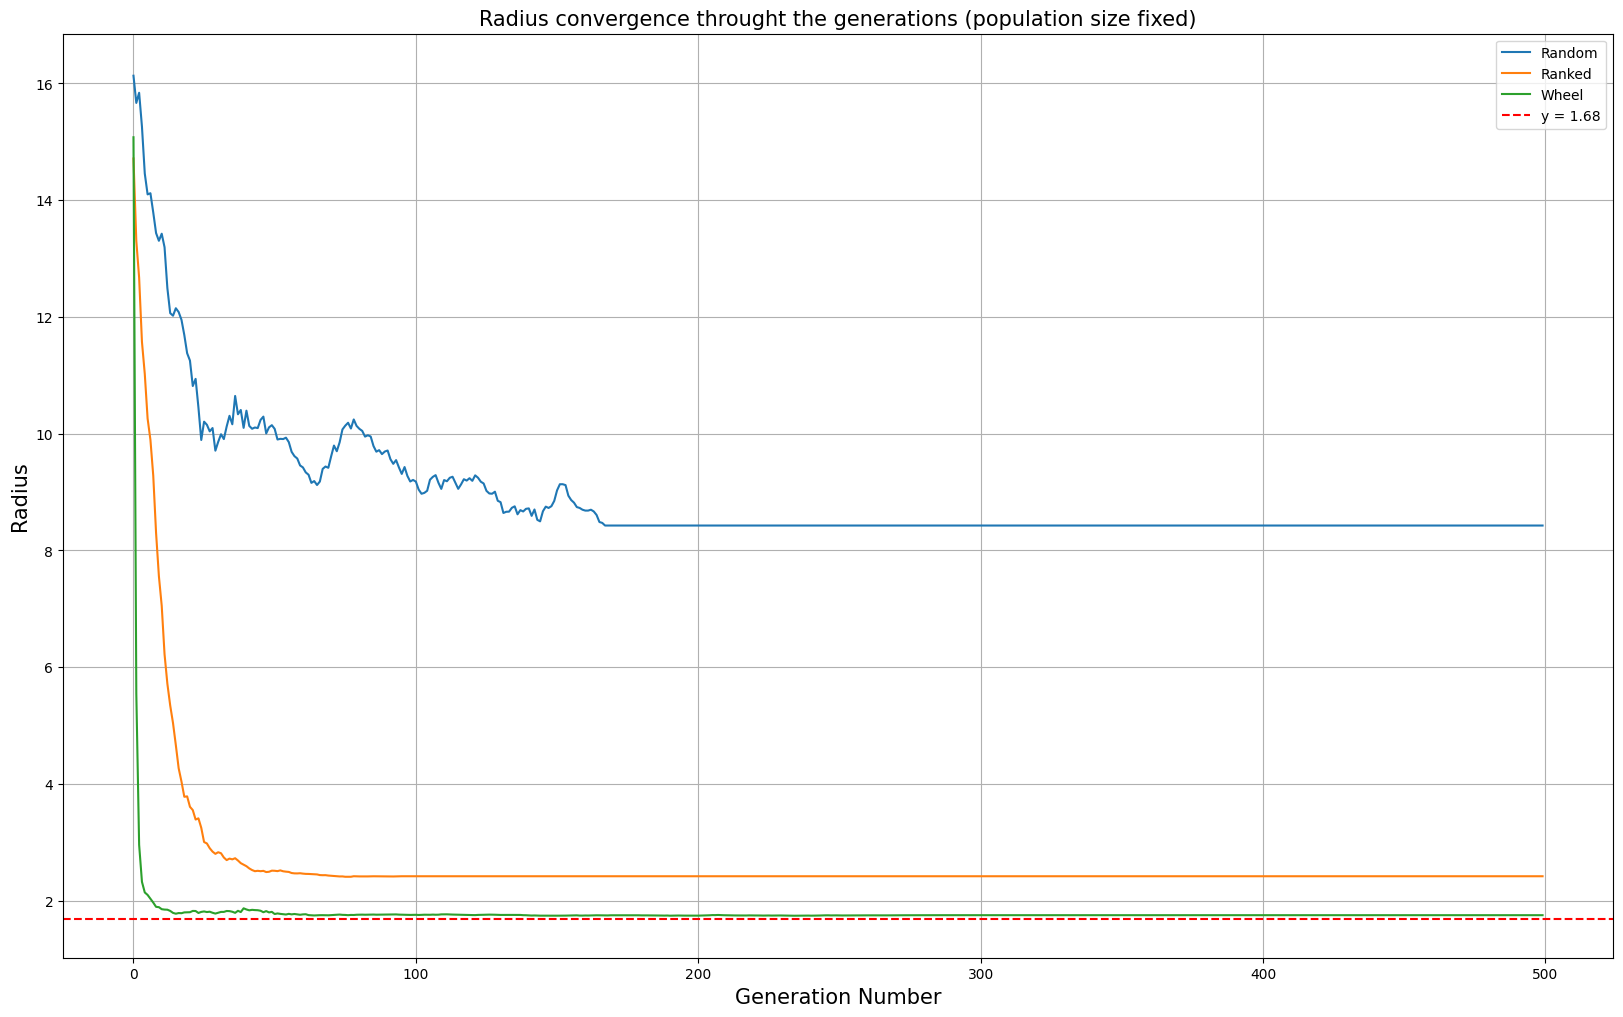

In [11]:
grouped = new_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.show()

In [12]:
grouped.loc['Random Selection', 'radius']

generation
0      16.132941
1      15.666588
2      15.841176
3      15.260941
4      14.457176
         ...    
495     8.427059
496     8.427059
497     8.427059
498     8.427059
499     8.427059
Name: radius, Length: 500, dtype: float64

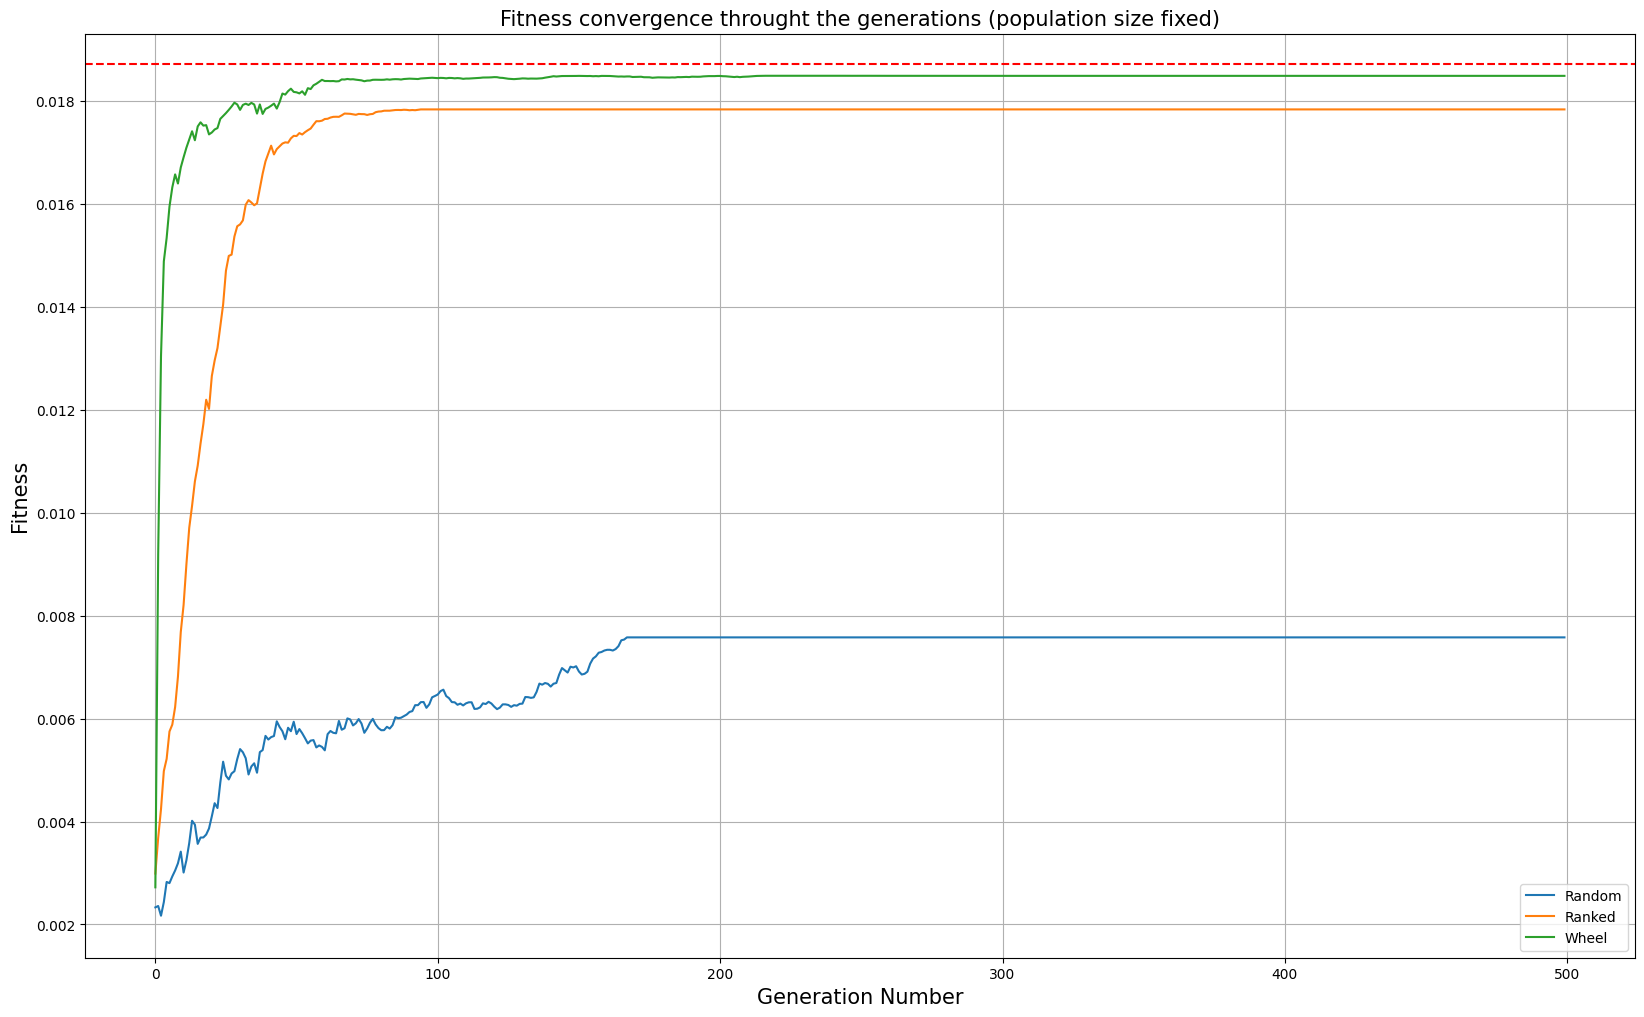

In [13]:
grouped = new_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'fitness']
y2 = grouped.loc['Ranked Selection', 'fitness']
y3 = grouped.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')

plt.show()

In [14]:
new_generations_df.groupby(by=['selection_type', 'pop_size']).describe(percentiles = [0.5])

radius                                            \
                             count       mean       std       min        50%   
selection_type   pop_size                                                      
Random Selection 5          2500.0  10.643059  0.536929  9.294118  10.588235   
                 15         7500.0  12.817522  1.079883  4.705882  12.705882   
                 25        12500.0   6.004998  1.294756  0.117647   5.882353   
                 35        17500.0   4.077271  2.086540  0.117647   3.764706   
                 45        22500.0   2.710264  3.342176  0.117647   1.882353   
                 55        27500.0   1.930481  3.098096  0.352941   1.058824   
                 65        32500.0  15.886671  2.706291  0.235294  15.294118   
                 75        37500.0  23.139893  3.788395  0.117647  24.470588   
                 85        42500.0   5.984974  4.116264  0.117647   4.117647   
                 95        47500.0   4.411980  2.100264  0.117647   3.882353   
Ranked Selection 5          2500.0   0.681600  1.917252  0.470588   0.470588   
                 15         7500.0  22.594839  0.959842  0.470588  22.588235   
                 25        12500.0   2.307304  2.607126  0.235294   1.882353   
                 35        17500.0   2.007503  1.514307  0.117647   1.882353   
                 45        22500.0   1.889846  1.808369  0.235294   1.647059   
                 55        27500.0   2.232920  1.326650  0.117647   2.117647   
                 65        32500.0   2.360822  2.574209  0.117647   1.882353   
                 75        37500.0   1.855664  1.778711  0.117647   1.647059   
                 85        42500.0   1.784933  1.407579  0.117647   1.647059   
                 95        47500.0   2.206269  2.037705  0.117647   1.882353   
Wheel Selection  5          2500.0   2.037412  0.689225  0.588235   2.000000   
                 15         7500.0   2.526086  0.751275  2.117647   2.470588   
                 25        12500.0   1.575473  0.775728  0.117647   1.529412   
                 35        17500.0   1.692578  0.777379  0.235294   1.647059   
                 45        22500.0   1.496099  0.768422  0.117647   1.411765   
                 55        27500.0   1.980051  0.893807  0.117647   1.882353   
                 65        32500.0   1.760503  0.818628  0.235294   1.764706   
                 75        37500.0   1.795975  0.788663  0.117647   1.764706   
                 85        42500.0   1.699870  0.805777  0.117647   1.647059   
                 95        47500.0   1.919415  0.746185  0.117647   1.882353   

                                     generation                          ...  \
                                 max      count   mean         std  min  ...   
selection_type   pop_size                                                ...   
Random Selection 5         26.823529     2500.0  249.5  144.366155  0.0  ...   
                 15        28.823529     7500.0  249.5  144.346902  0.0  ...   
                 25        30.000000    12500.0  249.5  144.343052  0.0  ...   
                 35        29.882353    17500.0  249.5  144.341403  0.0  ...   
                 45        30.000000    22500.0  249.5  144.340486  0.0  ...   
                 55        29.294118    27500.0  249.5  144.339903  0.0  ...   
                 65        30.000000    32500.0  249.5  144.339499  0.0  ...   
                 75        29.882353    37500.0  249.5  144.339203  0.0  ...   
                 85        30.000000    42500.0  249.5  144.338977  0.0  ...   
                 95        30.000000    47500.0  249.5  144.338798  0.0  ...   
Ranked Selection 5         29.529412     2500.0  249.5  144.366155  0.0  ...   
                 15        29.882353     7500.0  249.5  144.346902  0.0  ...   
                 25        29.411765    12500.0  249.5  144.343052  0.0  ...   
                 35        29.764706    17500.0  249.5  144.341403  0.0  ...   
                 45        

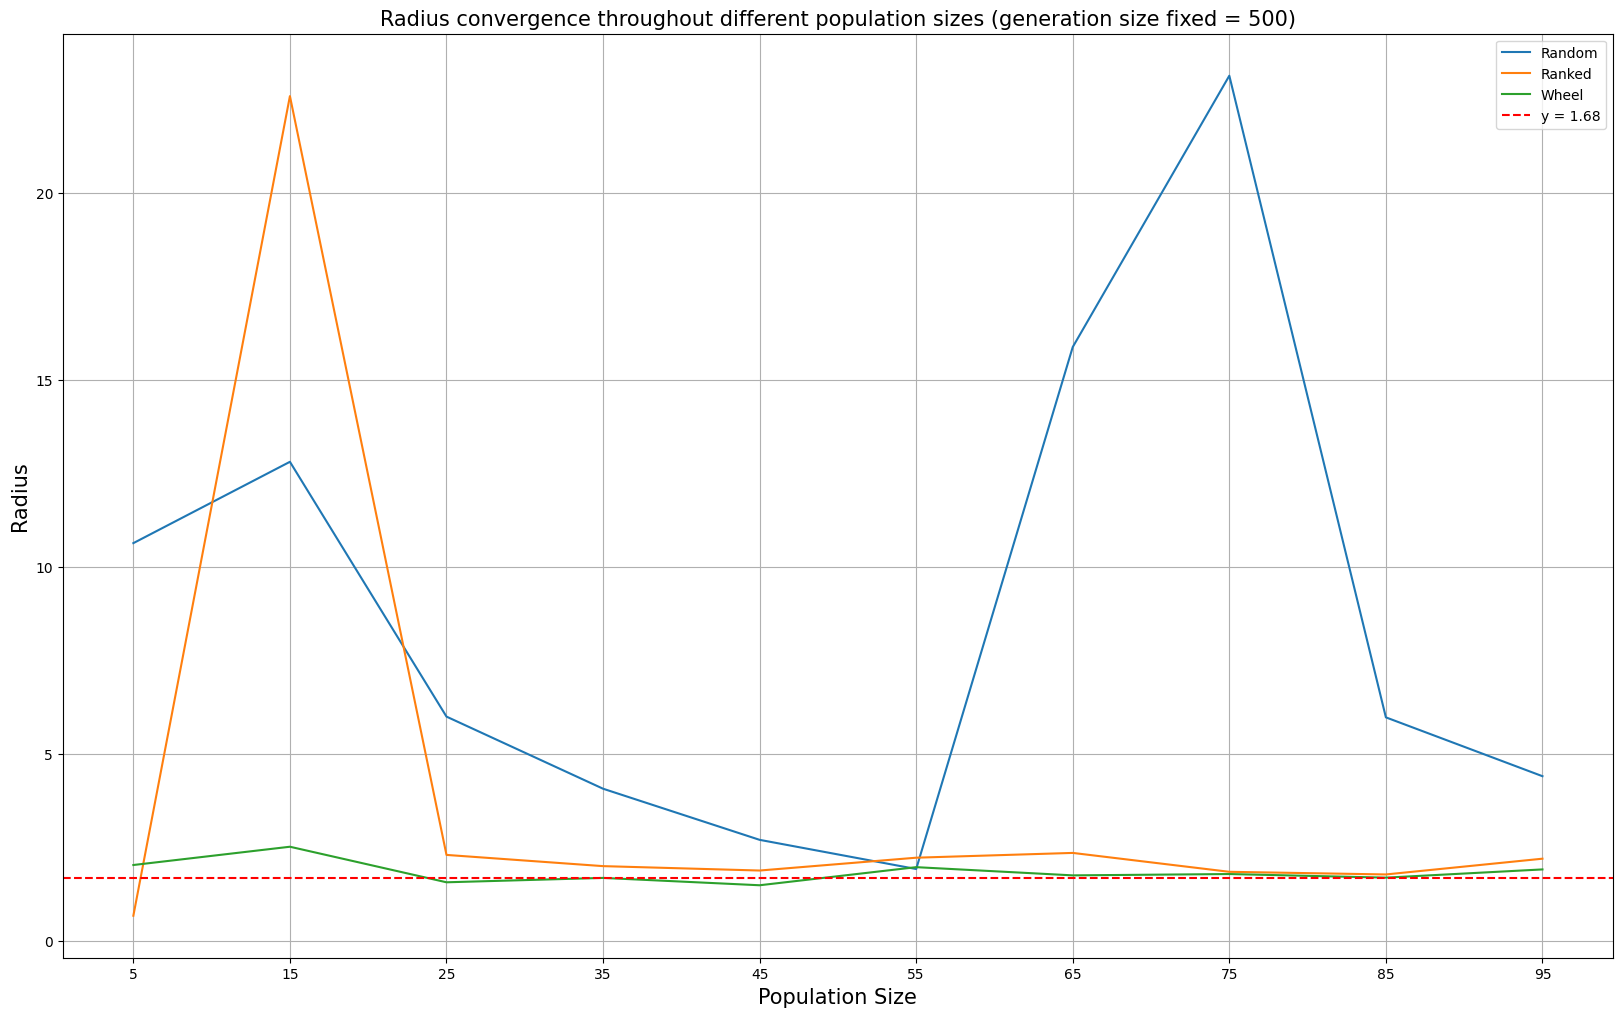

In [15]:
grouped_pop = new_generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'radius']))
y1 = grouped_pop.loc['Random Selection', 'radius']
y2 = grouped_pop.loc['Ranked Selection', 'radius']
y3 = grouped_pop.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  

plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.show()

In [16]:
grouped_pop.loc['Random Selection', 'radius'].values

array([10.64305882, 12.81752157,  6.00499765,  4.07727059,  2.71026405,
        1.93048128, 15.88667149, 23.13989333,  5.98497439,  4.41198019])

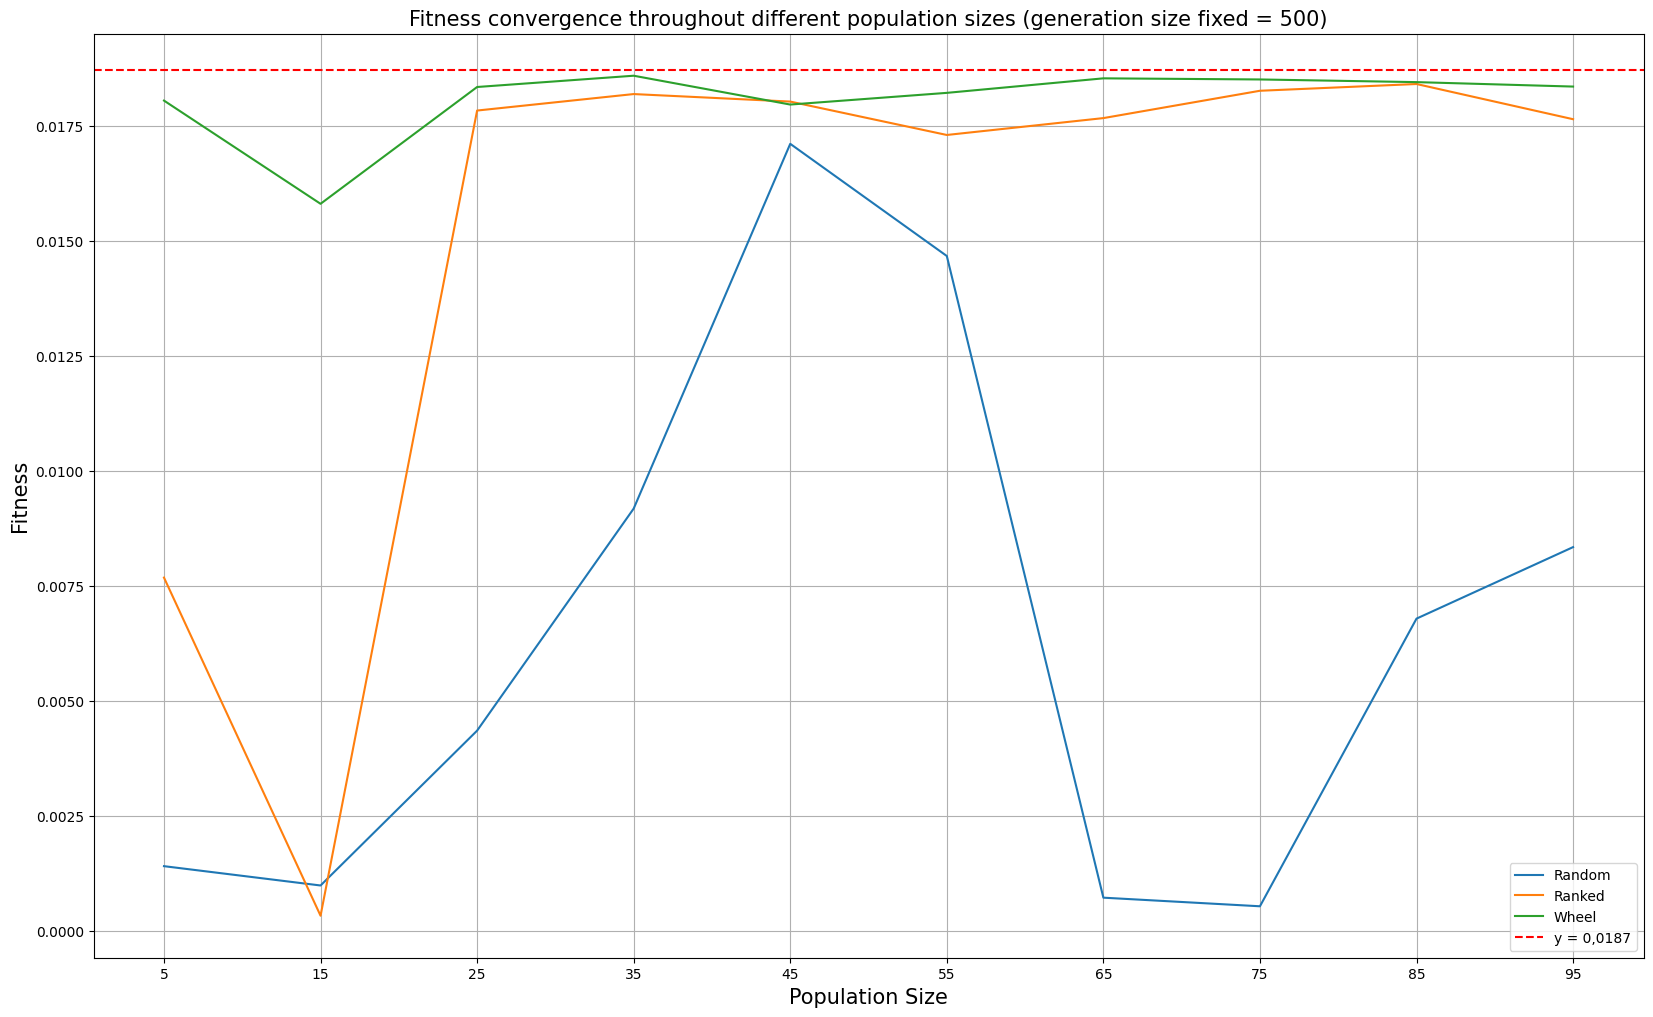

In [17]:
grouped_pop = new_generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'fitness']))
y1 = grouped_pop.loc['Random Selection', 'fitness']
y2 = grouped_pop.loc['Ranked Selection', 'fitness']
y3 = grouped_pop.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')
plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.legend()

plt.show()

WITH MUTATIONS

In [18]:
mutation_generations_df=generations_df[generations_df['mutation']!=0]
#checking the results
mutation_generations_df.sample(5)

,radius,generation,fitness,selection_type,pop_size,mutation
1250277,0.941176,55,0.014427,Wheel Selection,5,0.001
819336,0.941176,124,0.014427,Random Selection,55,0.001
1264355,1.882353,174,0.018471,Wheel Selection,25,0.001
1366510,1.411765,407,0.018174,Wheel Selection,65,0.001
908971,1.882353,486,0.018471,Random Selection,75,0.001


In [19]:
#Sample Statistics
mutation_generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])

radius                                            \
                             count       mean       std       min        50%   
selection_type   generation                                                    
Random Selection 0           500.0  15.216706  8.536751  0.117647  15.941176   
                 1           500.0  14.912000  8.388420  0.117647  15.764706   
                 2           500.0  14.510824  8.467481  0.117647  15.117647   
                 3           500.0  13.854824  8.421758  0.117647  12.882353   
                 4           500.0  13.044235  8.466953  0.117647  11.764706   
...                            ...        ...       ...       ...        ...   
Wheel Selection  495         500.0   1.854824  0.740995  1.411765   1.882353   
                 496         500.0   1.853176  0.643545  1.411765   1.882353   
                 497         500.0   1.863294  0.963629  0.470588   1.882353   
                 498         500.0   1.842588  0.743056  1.411765   1.882353   
                 499         500.0   1.793647  0.184613  1.411765   1.882353   

                                       fitness                                \
                                   max   count      mean       std       min   
selection_type   generation                                                    
Random Selection 0           30.000000   500.0  0.002872  0.004760  0.000177   
                 1           29.882353   500.0  0.002883  0.004783  0.000178   
                 2           29.647059   500.0  0.003021  0.004876  0.000181   
                 3           29.882353   500.0  0.003228  0.005028  0.000178   
                 4           30.000000   500.0  0.003797  0.005575  0.000177   
...                                ...     ...       ...       ...       ...   
Wheel Selection  495         16.588235   500.0  0.018289  0.001351  0.000577   
                 496          9.411765   500.0  0.018274  0.001473  0.001776   
                 497         16.470588   500.0  0.018297  0.001415  0.000585   
                 498         16.941176   500.0  0.018323  0.001200  0.000553   
                 499          2.352941   500.0  0.018423  0.000199  0.016588   

                             ...   pop_size                  mutation         \
                             ...        std  min   50%   max    count   mean   
selection_type   generation  ...                                               
Random Selection 0           ...  23.534182  5.0  75.0  95.0    500.0  0.001   
                 1           ...  23.534182  5.0  75.0  95.0    500.0  0.001   
                 2           ...  23.534182  5.0  75.0  95.0    500.0  0.001   
                 3           ...  23.534182  5.0  75.0  95.0    500.0  0.001   
                 4           ...  23.534182  5.0  75.0  95.0    500.0  0.001   
...                          ...        ...  ...   ...   ...      ...    ...   
Wheel Selection  495         ...  23.534182  5.0  75.0  95.0    500.0  0.001   
                 496         ...  23.534182  5.0  75.0  95.0    500.0  0.001   
                 497         ...  23.534182  5.0  75.0  95.0    500.0  0.001   
                 498         ...  23.534182  5.0  75.0  95.0    500.0  0.001   
                 499         ...  23.534182  5.0  75.0  95.0    500.0  0.001   

                                                                
                                      std    min    50%    max  
selection_type   generation                                     
Random Selection 0           4.341152e-19  0.001  0.001  0.001  
                 1           4.341152e-19  0.001  0.001  0.001  
                 2           4.341152e-19  0.001  0.001  0.001  
                 3           4.341152e-19  0.001  0.001  0.001  
                 4           4.341152e-19  0.001  0.001  0.001  
...                                   ...    ...    ...    ...  
Wheel Selection  495         4.341152e-19  0.001  0.001  0.001  
               

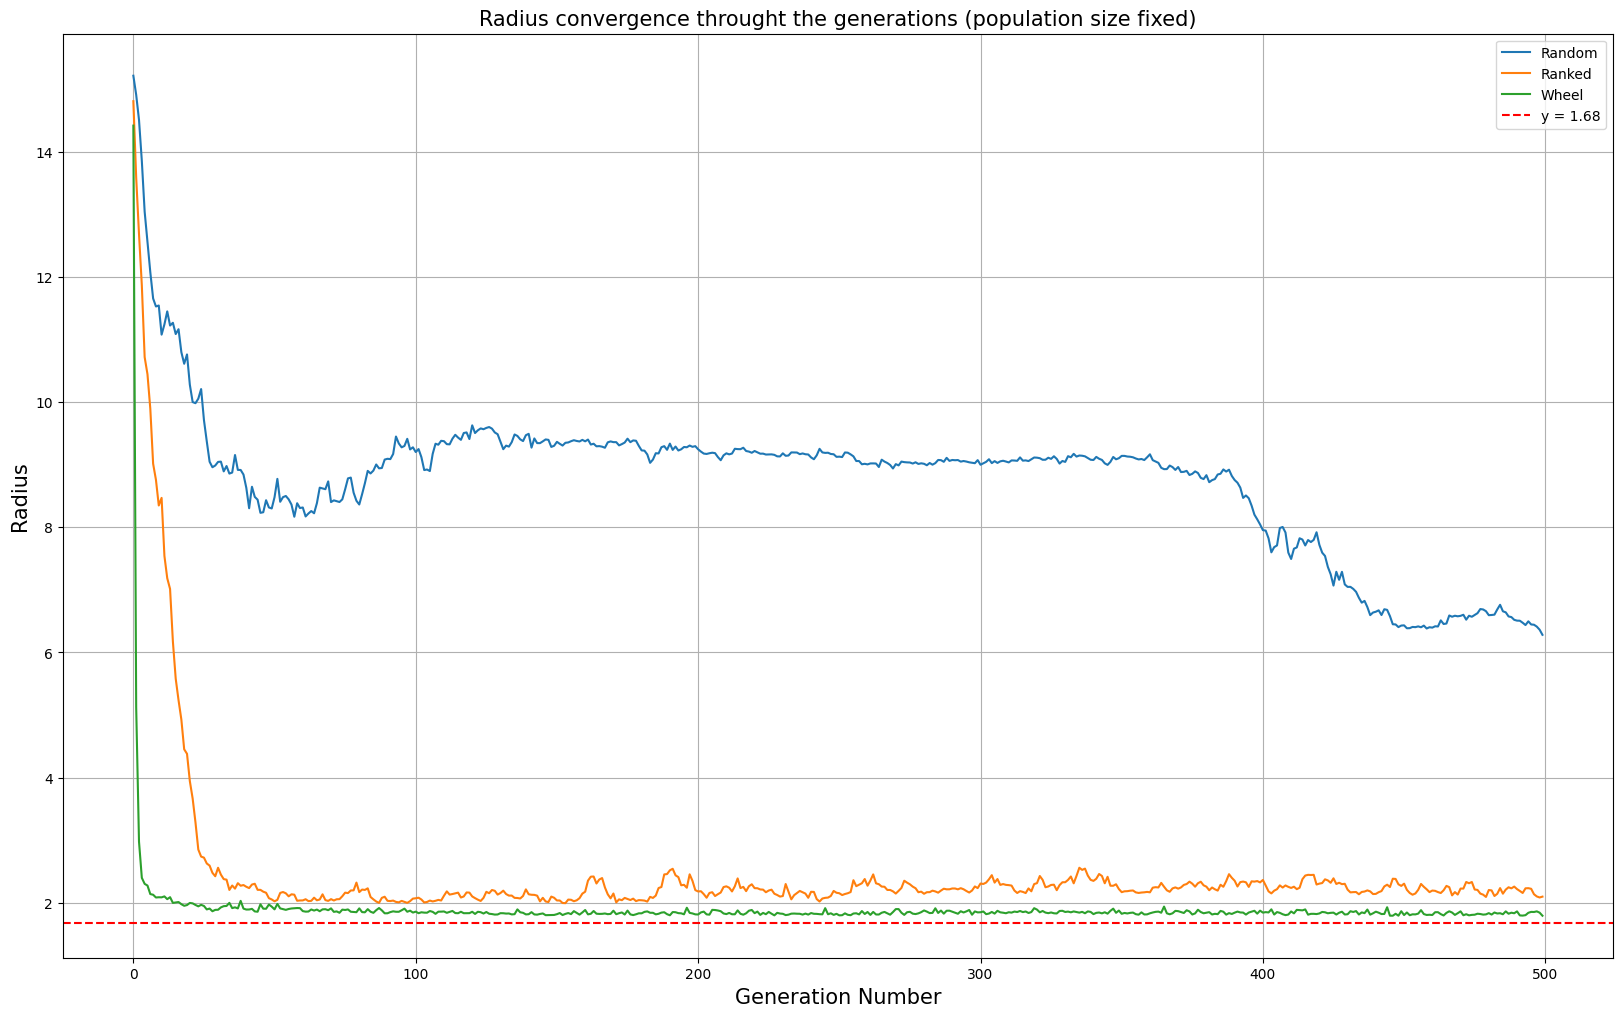

In [20]:
grouped = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.show()

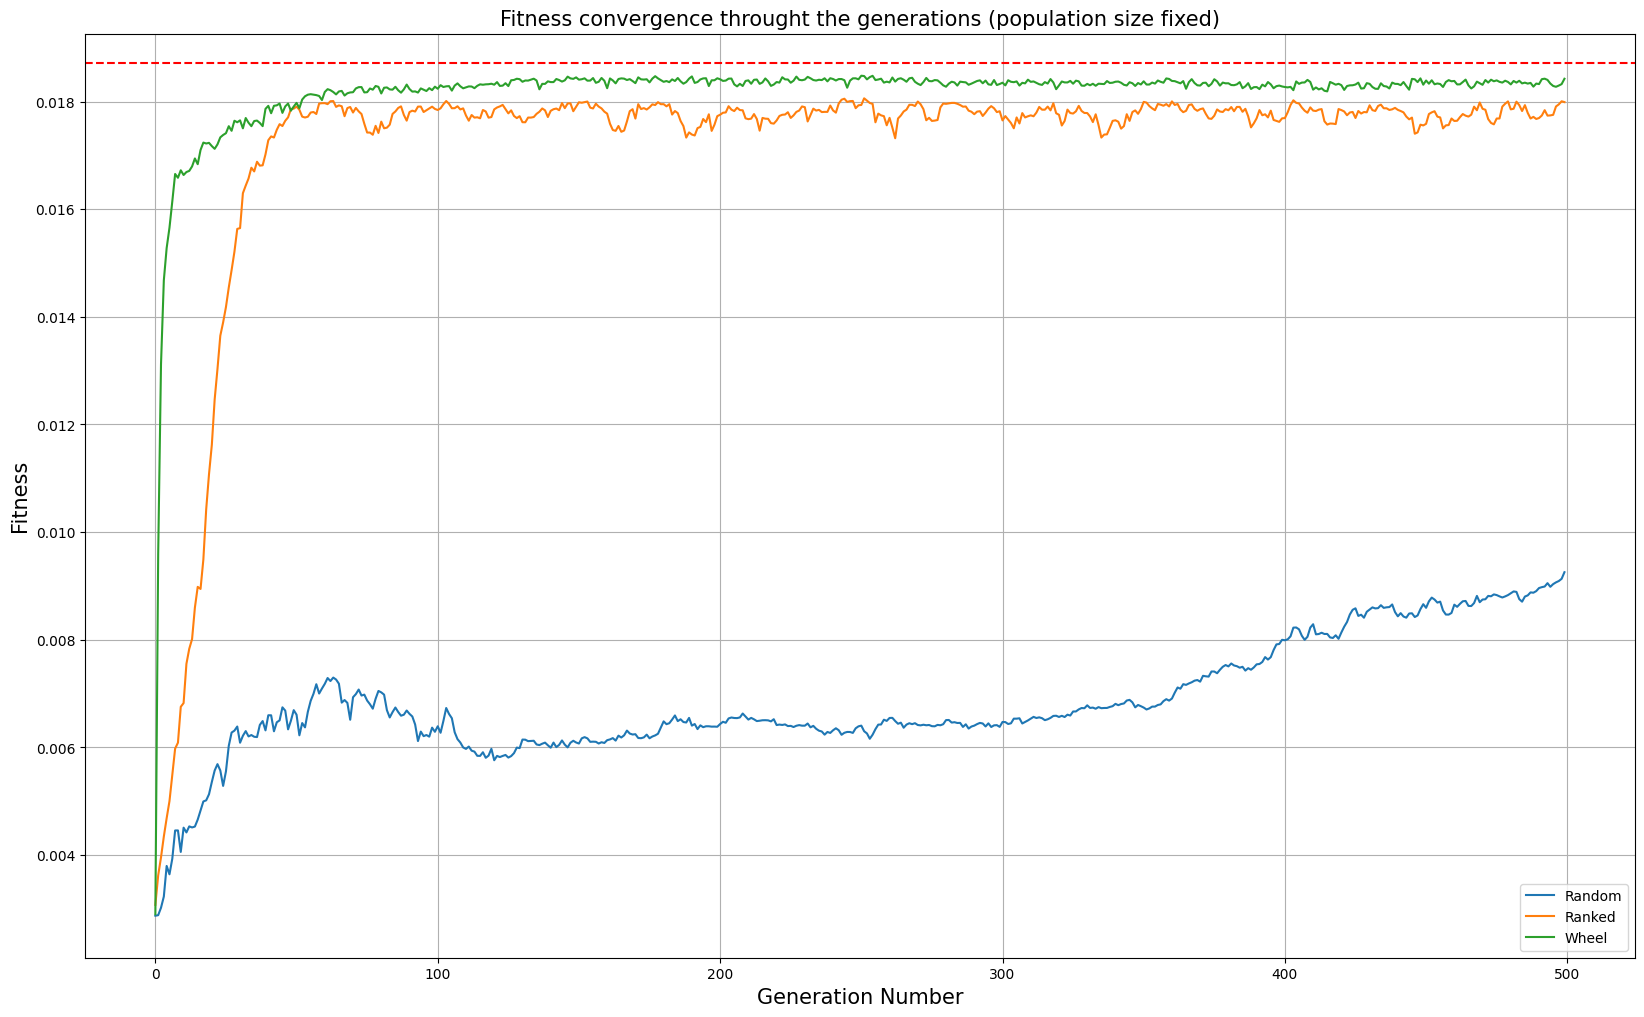

In [21]:
grouped = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'fitness']
y2 = grouped.loc['Ranked Selection', 'fitness']
y3 = grouped.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')

plt.show()

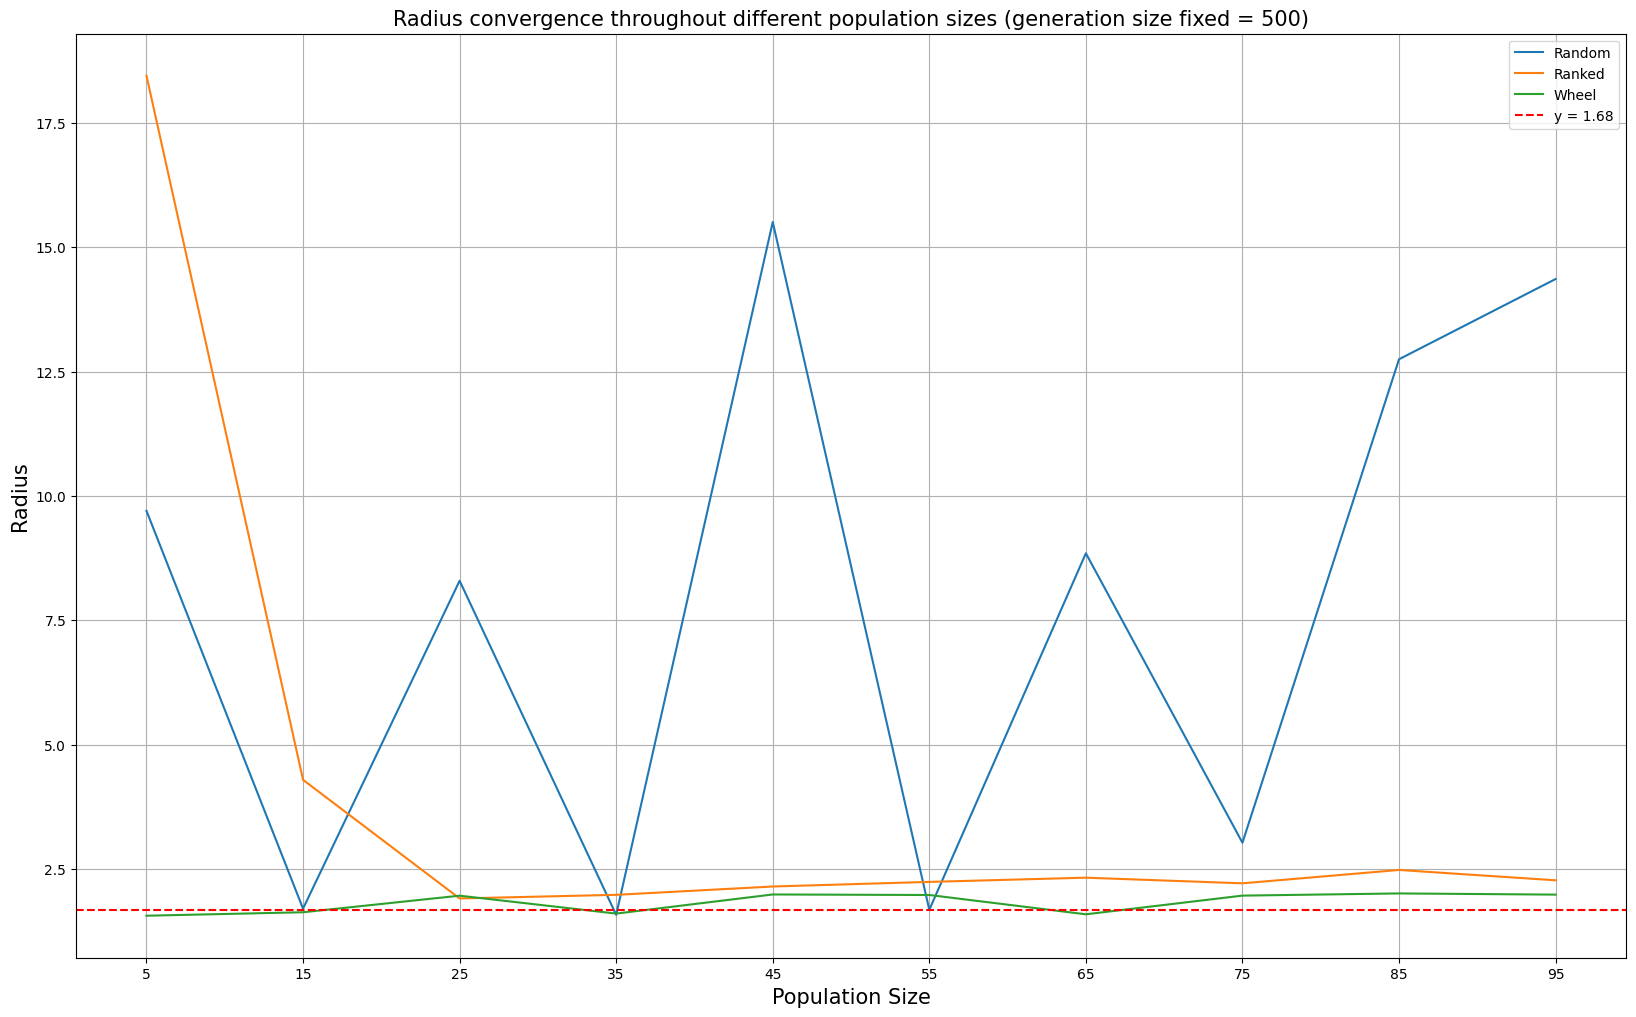

In [22]:
grouped_pop = mutation_generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'radius']))
y1 = grouped_pop.loc['Random Selection', 'radius']
y2 = grouped_pop.loc['Ranked Selection', 'radius']
y3 = grouped_pop.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  

plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.show()

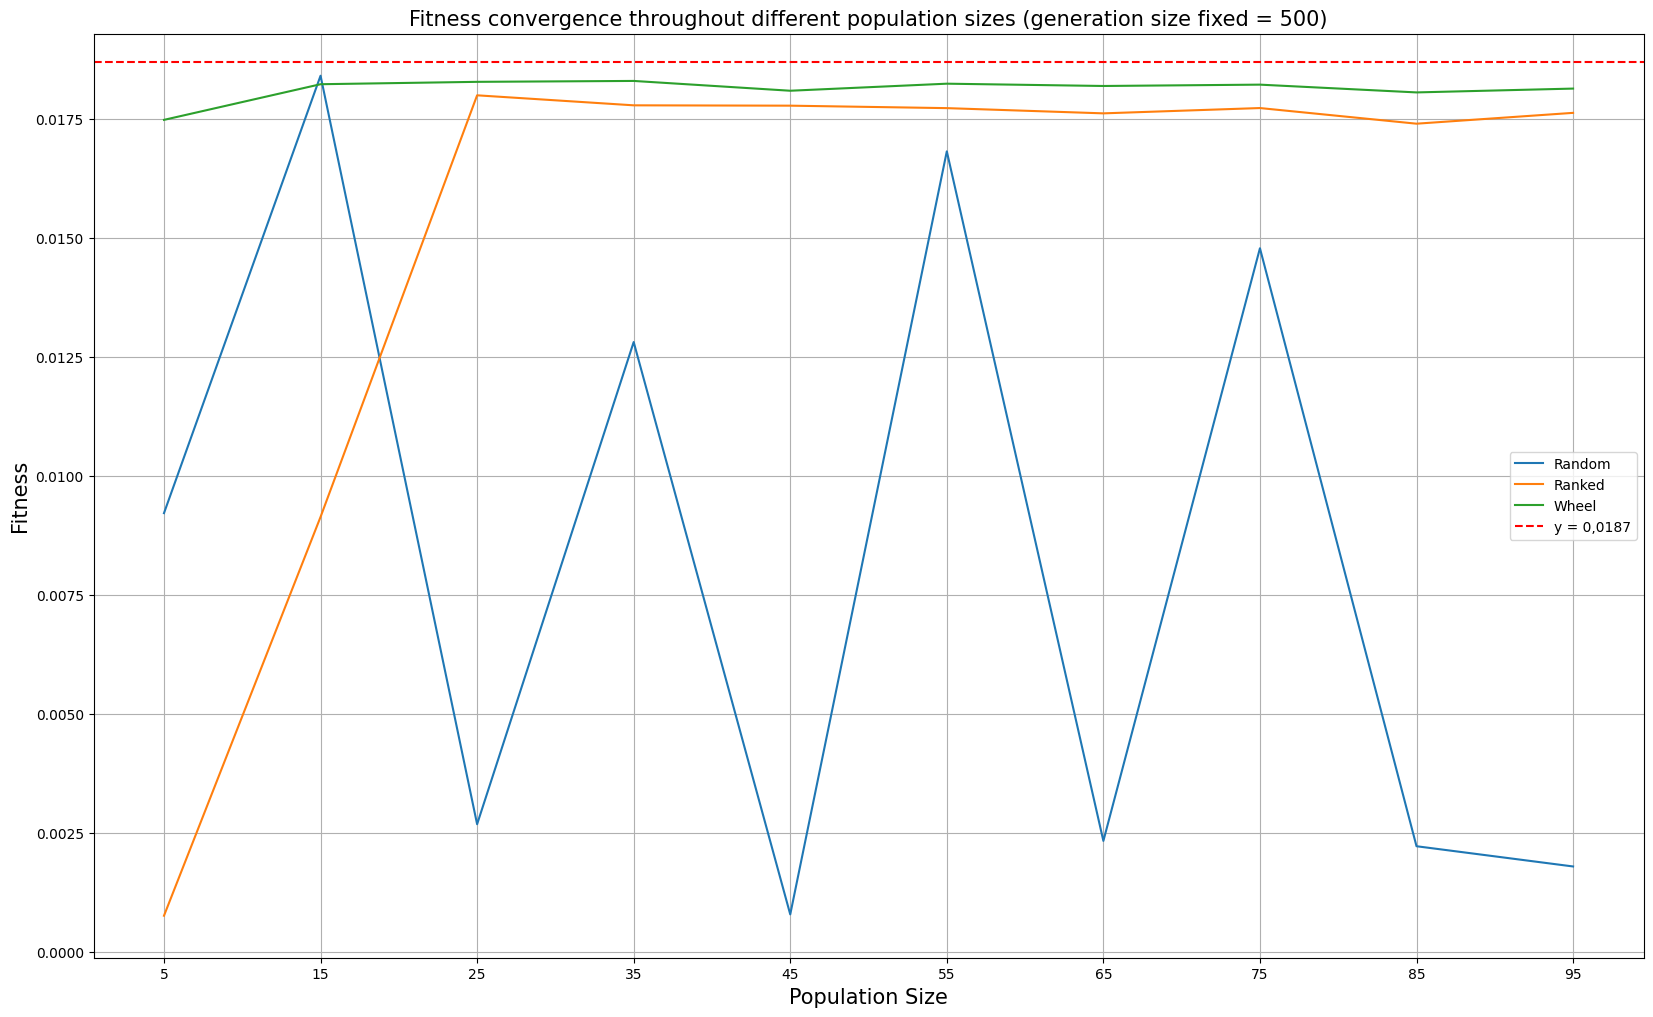

In [23]:
grouped_pop = mutation_generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'fitness']))
y1 = grouped_pop.loc['Random Selection', 'fitness']
y2 = grouped_pop.loc['Ranked Selection', 'fitness']
y3 = grouped_pop.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')
plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.legend()

plt.show()